In [1]:
!pip install tf-nightly-2.0-preview


    100% |████████████████████████████████| 109.5MB 385kB/s ta 0:00:011
    100% |████████████████████████████████| 450kB 5.3MB/s ta 0:00:011
    100% |████████████████████████████████| 3.8MB 3.8MB/s ta 0:00:011
tensorflow 2.0.0b1 has requirement tb-nightly<1.14.0a20190604,>=1.14.0a20190603, but you'll have tb-nightly 2.1.0a20191206 which is incompatible.
tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.21.1 which is incompatible.
tb-nightly 2.1.0a20191206 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.
  Found existing installation: tb-nightly 1.14.0a20190603
    Uninstalling tb-nightly-1.14.0a20190603:
      Successfully uninstalled tb-nightly-1.14.0a20190603


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [38]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#     dataset = tf.data.Dataset.from_tensor_slices(series)\
#                 .window(window_size+1, shift=1, drop_remainder=True)\
#                 .flat_map(lambda window: window.batch(window_size+1))\
#                 .shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[1]))\
#                 .batch(batch_size).prefetch(1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [39]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, 
                                                            momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

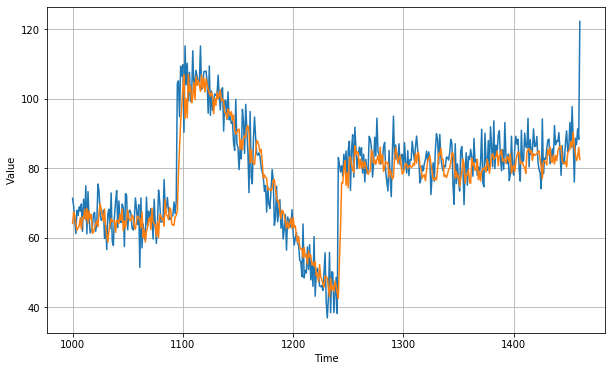

In [41]:
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [42]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1154356

In [43]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, 
                    epochs=100, 
                    callbacks=[lr_schedule],
                   verbose=0)

[1e-08, 0.001, 0, 300]

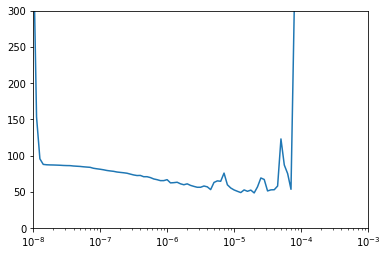

In [44]:
lrs = 1e-8*(10**(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [45]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

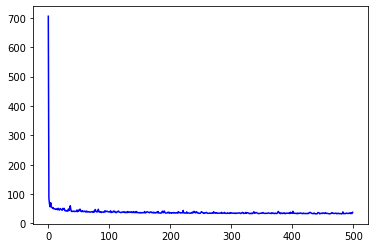

In [46]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[49.870121725809945, 48.832566322248006, 47.5604565728571, 49.216744700166366, 49.66829633417818, 46.29958304965619, 51.44619429283535, 48.4105236368081, 45.18267520235986, 48.7262964897549, 50.57146794427302, 47.0135228107885, 45.784037332436476, 45.0551791869488, 51.07311098551013, 48.03612416847465, 51.04708592523004, 43.719827270507814, 43.98410615429436, 42.51669462538257, 43.61432370844575, 41.77331703815263, 41.80705966752829, 49.133423378541295, 43.838009910976766, 48.471505760900754, 60.02578316128131, 46.2307344967557, 40.59066079129878, 41.57483697478304, 40.32951016376928, 41.30854616656746, 42.04164182918588, 40.343169819939995, 40.897151994213615, 41.0132551684822, 40.86609619769853, 45.56749689161163, 39.94138630345925, 41.13106269443158, 45.615276218689594, 43.11742131341364, 48.56864819870782, 41.81865965853032, 41.771137646547295, 39.5306548836305, 43.19873454300399, 41.37674828755487, 39.9937448757211, 40.95782020804808, 42.060521981150835, 39.04192202066638, 38.8512

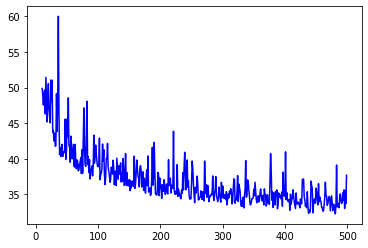

In [47]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

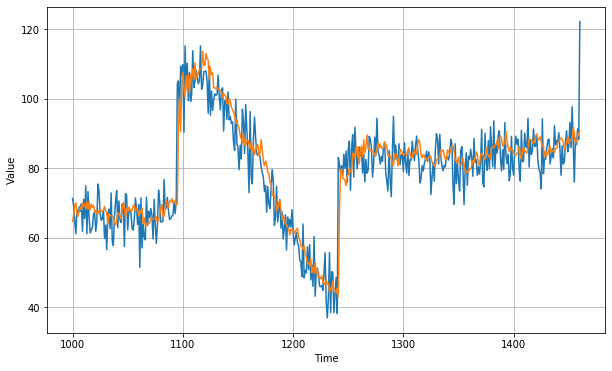

In [48]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [49]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.909686

# LSTM

In [50]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 139ms/step - loss: 21.5079 - mae: 21.8908
Epoch 2/100
31/31 [==============================] - 1s 25ms/step - loss: 21.1587 - mae: 21.5620
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 20.6838 - mae: 21.2036
Epoch 4/100
31/31 [==============================] - 1s 25ms/step - loss: 20.4923 - mae: 20.8227
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 19.7948 - mae: 20.3989
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 19.3325 - mae: 19.9375
Epoch 7/100
31/31 [==============================] - 1s 25ms/step - loss: 18.7315 - mae: 19.3190
Epoch 8/100
31/31 [==============================] - 1s 26ms/step - loss: 17.6315 - mae: 18.1549
Epoch 9/100
31/31 [==============================] - 1s 26ms/step - loss: 17.0986 - mae: 17.6978
Epoch 10/100
31/31 [==============================] - 1s 26ms/step - loss: 16.9206 - mae: 17.4698
Epoch 11/100
31/31 [========

31/31 [==============================] - 1s 29ms/step - loss: 9.5616 - mae: 10.1382
Epoch 86/100
31/31 [==============================] - 1s 28ms/step - loss: 5.8856 - mae: 6.4272
Epoch 87/100
31/31 [==============================] - 1s 29ms/step - loss: 6.2889 - mae: 6.7433
Epoch 88/100
31/31 [==============================] - 1s 28ms/step - loss: 6.9285 - mae: 7.4248
Epoch 89/100
31/31 [==============================] - 1s 28ms/step - loss: 6.6456 - mae: 7.2024
Epoch 90/100
31/31 [==============================] - 1s 30ms/step - loss: 7.1574 - mae: 7.6360
Epoch 91/100
31/31 [==============================] - 1s 29ms/step - loss: 7.8239 - mae: 8.3427
Epoch 92/100
31/31 [==============================] - 1s 29ms/step - loss: 6.2896 - mae: 6.5941
Epoch 93/100
31/31 [==============================] - 1s 29ms/step - loss: 9.0006 - mae: 9.5629
Epoch 94/100
31/31 [==============================] - 1s 30ms/step - loss: 10.5443 - mae: 11.0594
Epoch 95/100
31/31 [==============================

[1e-08, 0.0001, 0, 30]

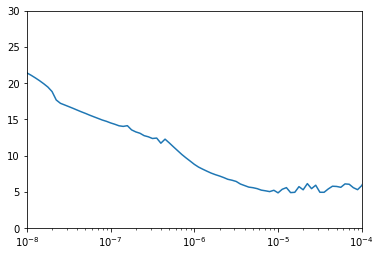

In [51]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [52]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

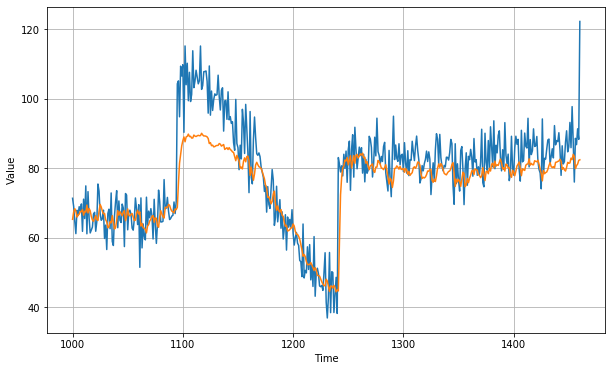

In [53]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [54]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.220784

<Figure size 432x288 with 0 Axes>

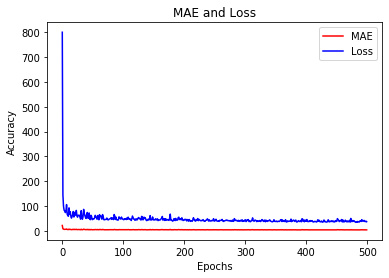

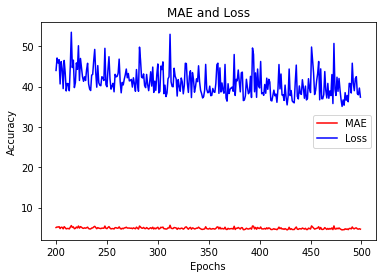

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [56]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [57]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 197ms/step - loss: 743.4846
Epoch 2/100
31/31 [==============================] - 1s 41ms/step - loss: 167.1592
Epoch 3/100
31/31 [==============================] - 1s 42ms/step - loss: 107.2006
Epoch 4/100
31/31 [==============================] - 1s 42ms/step - loss: 92.6650
Epoch 5/100
31/31 [==============================] - 1s 43ms/step - loss: 79.2568
Epoch 6/100
31/31 [==============================] - 1s 46ms/step - loss: 71.6686
Epoch 7/100
31/31 [==============================] - 1s 45ms/step - loss: 66.5321
Epoch 8/100
31/31 [==============================] - 1s 45ms/step - loss: 62.3723
Epoch 9/100
31/31 [==============================] - 1s 45ms/step - loss: 55.5577
Epoch 10/100
31/31 [==============================] - 1s 45ms/step - loss: 54.2557
Epoch 11/100
31/31 [==============================] - 1s 45ms/step - loss: 54.8817
Epoch 12/100
31/31 [==============================] - 1s 44ms/step - loss: 58.6785
Epoch 13/

31/31 [==============================] - 1s 45ms/step - loss: 44.8148
Epoch 100/100
31/31 [==============================] - 1s 44ms/step - loss: 44.8615


# CNN + LSTM

In [64]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [65]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 569ms/step - loss: 73.2800 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 0s 53ms/step - loss: 72.3807 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 0s 54ms/step - loss: 71.2596 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 0s 55ms/step - loss: 69.8434 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 0s 58ms/step - loss: 68.2533 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 0s 50ms/step - loss: 66.3086 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 0s 59ms/step - loss: 64.2200 - mae: 64.7353
Epoch 8/100
8/8 [==============================] - 0s 56ms/step - loss: 61.7602 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 0s 56ms/step - loss: 59.1640 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 0s 55ms/step - loss: 56.3343 - mae: 56.8317
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 58ms/step - loss: 29.7017 - mae: 29.6637
Epoch 88/100
8/8 [==============================] - 0s 58ms/step - loss: 18.0494 - mae: 18.6416
Epoch 89/100
8/8 [==============================] - 0s 58ms/step - loss: 14.9587 - mae: 15.4874
Epoch 90/100
8/8 [==============================] - 0s 57ms/step - loss: 22.2564 - mae: 23.0060
Epoch 91/100
8/8 [==============================] - 0s 58ms/step - loss: 32.5233 - mae: 33.0264
Epoch 92/100
8/8 [==============================] - 0s 58ms/step - loss: 22.3953 - mae: 23.1899
Epoch 93/100
8/8 [==============================] - 0s 57ms/step - loss: 15.0333 - mae: 15.5015
Epoch 94/100
8/8 [==============================] - 0s 56ms/step - loss: 16.8223 - mae: 17.4641
Epoch 95/100
8/8 [==============================] - 0s 59ms/step - loss: 17.2277 - mae: 17.8156
Epoch 96/100
8/8 [==============================] - 0s 58ms/step - loss: 19.7183 - mae: 19.2698
Epoch 97/100
8/8 [==============================] - 0

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

[1e-08, 0.0001, 0, 30]

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()